In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt


In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,calculate_shift_value


In [3]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [4]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/美元指数.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet = sheet[sheet['Date'] >= '2023-08-01']
sheet

,Date,美元指数,10年期美国国债收益率
8231,2023-08-01,101.9400,4.05
8232,2023-08-02,102.6416,4.08
8233,2023-08-03,102.4776,4.20
8234,2023-08-04,101.9986,4.05
8235,2023-08-07,102.0776,4.09
...,...,...,...
8820,2025-11-03,99.8723,4.13
8821,2025-11-04,100.2070,4.10
8822,2025-11-05,100.1592,4.17
8823,2025-11-06,99.7056,4.11


In [5]:
sheet1 = pd.read_excel('eta/10年期美国国债收益率_合并数据.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet1.set_index('Date', inplace=True) 
sheet1 = sheet1.reset_index().rename(columns={'index': 'Date'})
sheet1 = sheet1[['Date', '10年期美国国债收益率']].dropna(subset=['10年期美国国债收益率']).sort_values('Date')
sheet1.head()

,Date,10年期美国国债收益率
20,2025/11/06,4.14
19,2025/11/07,4.15
18,2025/11/10,4.16
17,2025/11/11,4.18
16,2025/11/12,4.16


In [6]:
sheet2 = pd.read_excel('eta/美元指数拟合残差-10年期美国国债收益率_合并数据.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet2.set_index('Date', inplace=True) 
sheet2 = sheet2.reset_index().rename(columns={'index': 'Date'})
sheet2 = sheet2[['Date', '预测值']].dropna(subset=['预测值']).sort_values('Date')
sheet2.head()

,Date,预测值
19,2025/11/10,-2.3077
18,2025/11/11,-2.3618
17,2025/11/12,-2.3488
16,2025/11/13,-2.3598
15,2025/11/14,-2.3756


In [7]:
# 转换 'Date' 列为 datetime 类型
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')

# 1. 合并 sheet 和 sheet1，使用 outer merge 保证所有日期都被保留
sheet_daily = pd.merge(sheet, sheet1, how='outer', on='Date', suffixes=('', '_sheet1'))

# 2. 处理 sheet2，将“预测值”列重命名为“美元指数拟合残差-10年期美国国债收益率”后合并
sheet2_renamed = sheet2[['Date', '预测值']].rename(columns={'预测值': '美元指数拟合残差-10年期美国国债收益率'})
sheet_daily = pd.merge(sheet_daily, sheet2_renamed, how='outer', on='Date')

# 3. 合并“10年期美国国债收益率”：若 sheet 中数据缺失，则使用 sheet1 中的数据填补
sheet_daily['10年期美国国债收益率'] = sheet_daily['10年期美国国债收益率'].fillna(sheet_daily['10年期美国国债收益率_sheet1'])
sheet_daily.drop(columns=['10年期美国国债收益率_sheet1'], inplace=True)

# 4. 按日期排序并重置索引
sheet_daily.sort_values("Date", inplace=True)
sheet_daily.reset_index(drop=True, inplace=True)

# 打印结果，查看合并后的数据
sheet_daily.head()

,Date,美元指数,10年期美国国债收益率,美元指数拟合残差-10年期美国国债收益率
0,2023-08-01,101.9400,4.05,NaN
1,2023-08-02,102.6416,4.08,NaN
2,2023-08-03,102.4776,4.20,NaN
3,2023-08-04,101.9986,4.05,NaN
4,2023-08-07,102.0776,4.09,NaN


In [8]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['美元指数_预测'] = 4.0868* sheet_daily['10年期美国国债收益率'] + 84.2839  + 0.8*sheet_daily['美元指数拟合残差-10年期美国国债收益率']
sheet_daily.tail()

,Date,美元指数,10年期美国国债收益率,美元指数拟合残差-10年期美国国债收益率,美元指数_预测
609,2025-12-01,NaN,4.11,-2.5316,99.055368
610,2025-12-02,NaN,4.11,-2.5366,99.051368
611,2025-12-03,NaN,4.12,-2.4792,99.138156
612,2025-12-04,NaN,NaN,-2.5319,NaN
613,2025-12-05,NaN,NaN,-2.4522,NaN


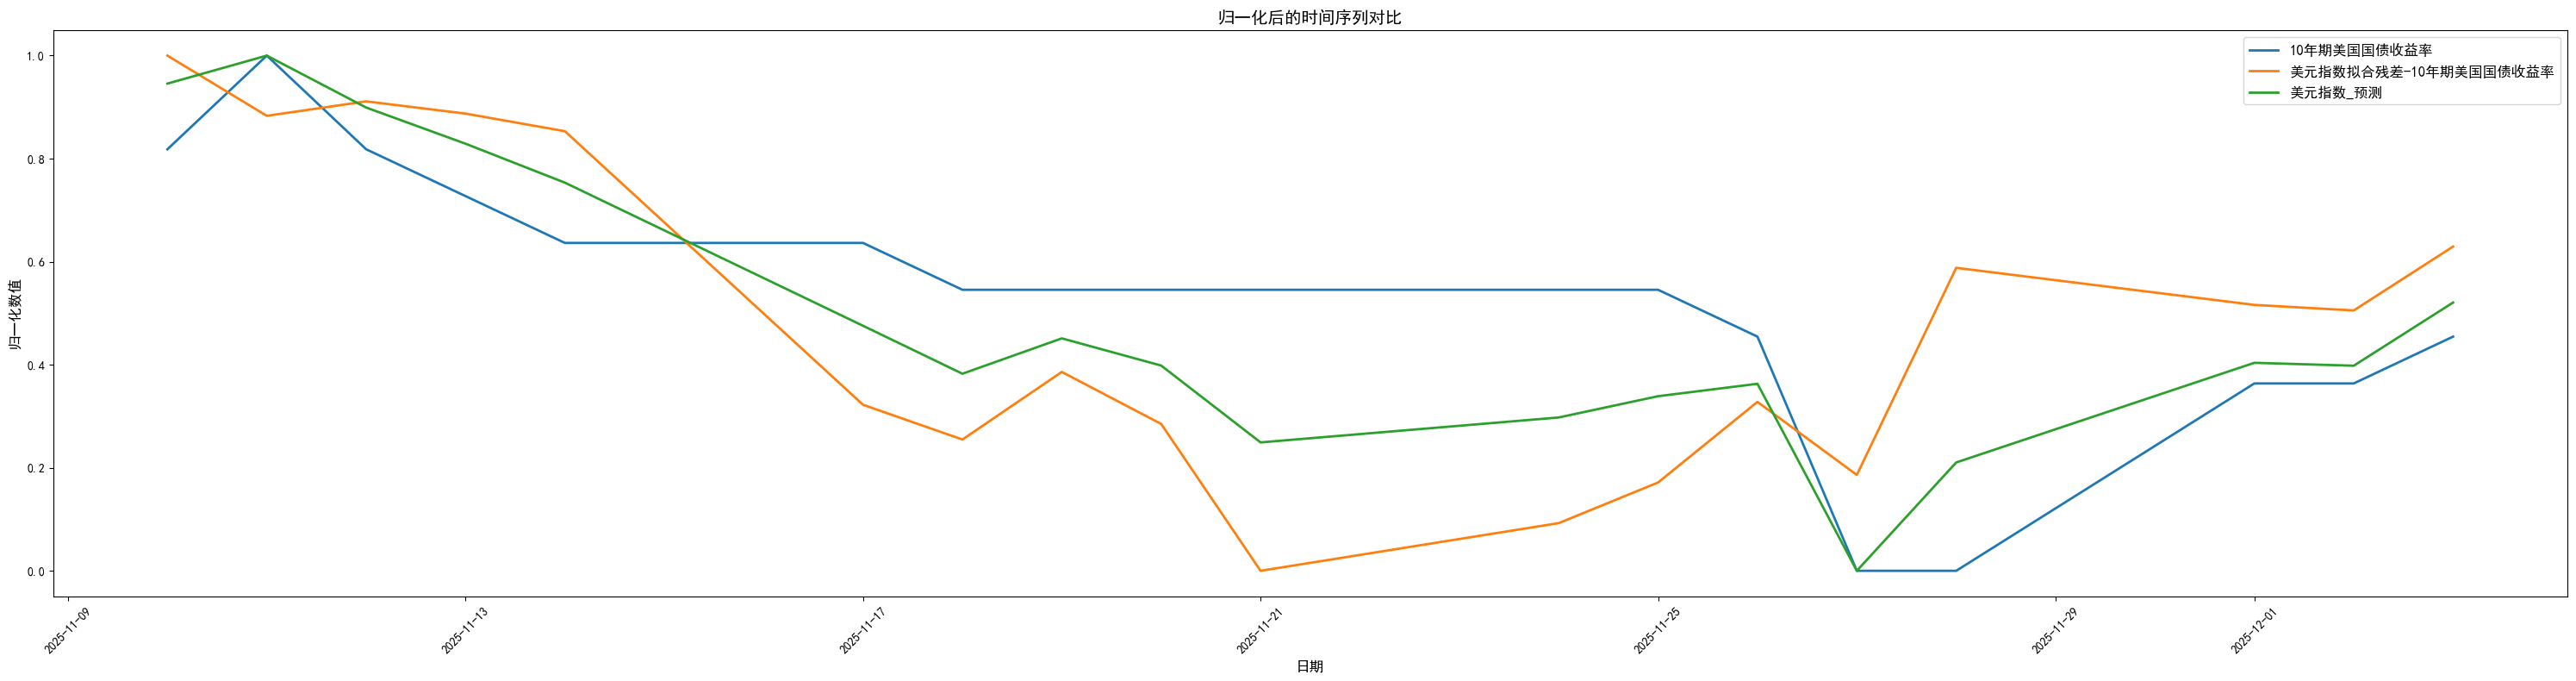

In [9]:
# 选择所有列都有值的数据
valid_data = sheet_daily.dropna(subset=['10年期美国国债收益率', '美元指数拟合残差-10年期美国国债收益率', '美元指数_预测'])

# 归一化处理
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 创建要归一化的数据框
data_to_normalize = valid_data[['10年期美国国债收益率', '美元指数拟合残差-10年期美国国债收益率', '美元指数_预测']]

# 进行归一化
normalized_data = pd.DataFrame(
    scaler.fit_transform(data_to_normalize),
    columns=data_to_normalize.columns,
    index=data_to_normalize.index
)

# 添加日期列
normalized_data['Date'] = valid_data['Date']


plt.figure(figsize=(30, 8))

# 绘制三条线
plt.plot(normalized_data['Date'], normalized_data['10年期美国国债收益率'], label='10年期美国国债收益率', linewidth=2)
plt.plot(normalized_data['Date'], normalized_data['美元指数拟合残差-10年期美国国债收益率'], label='美元指数拟合残差-10年期美国国债收益率', linewidth=2)
plt.plot(normalized_data['Date'], normalized_data['美元指数_预测'], label='美元指数_预测', linewidth=2)

# 设置图例和标签
plt.legend(fontsize=12)
plt.xlabel('日期', fontsize=12)
plt.ylabel('归一化数值', fontsize=12)
plt.title('归一化后的时间序列对比', fontsize=14)

# 旋转x轴标签以防重叠
plt.xticks(rotation=45)

# 调整布局
plt.tight_layout()


In [10]:
#from heapq import merge


last_day = sheet_daily['Date'][sheet_daily['美元指数'].last_valid_index()]
# 获取last_day之后的预测数据
future_predictions = sheet_daily[sheet_daily['Date'] > last_day][['Date', '美元指数_预测']]
future_predictions.to_csv('data_output/美元指数_未来日度预测.csv', index=False)
future_predictions.head()

,Date,美元指数_预测
594,2025-11-10,99.438828
595,2025-11-11,99.477284
596,2025-11-12,99.405948
597,2025-11-13,99.356280
598,2025-11-14,99.302772


---

In [11]:
# 创建一个新的 DataFrame，只包含 Date、美元指数 和 美元指数_预测 列
merged_df = sheet_daily[['Date', '美元指数', '美元指数_预测']]
# 按日期排序 倒叙
merged_df_daily = merged_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily = merged_df_daily.dropna(subset=['美元指数', '美元指数_预测'], how='all')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/美元指数_合并数据.xlsx', index=False,float_format='%.4f')

merged_df_monthly = merged_df.copy()
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/美元指数_月度数据.xlsx', index=False, float_format='%.4f')

In [12]:
merged_df_monthly = merged_df_monthly.dropna(subset=['美元指数', '美元指数_预测'], how='all')
merged_df_monthly


,Date,美元指数,美元指数_预测
28,2025/12/31,NaN,99.081631
27,2025/11/30,99.897980,99.127929
26,2025/10/31,98.746778,NaN
25,2025/09/30,97.693109,NaN
24,2025/08/31,98.225071,NaN
23,2025/07/31,97.949770,NaN
22,2025/06/30,98.386171,NaN
21,2025/05/31,100.090395,NaN
20,2025/04/30,100.677805,NaN
19,2025/03/31,104.130867,NaN


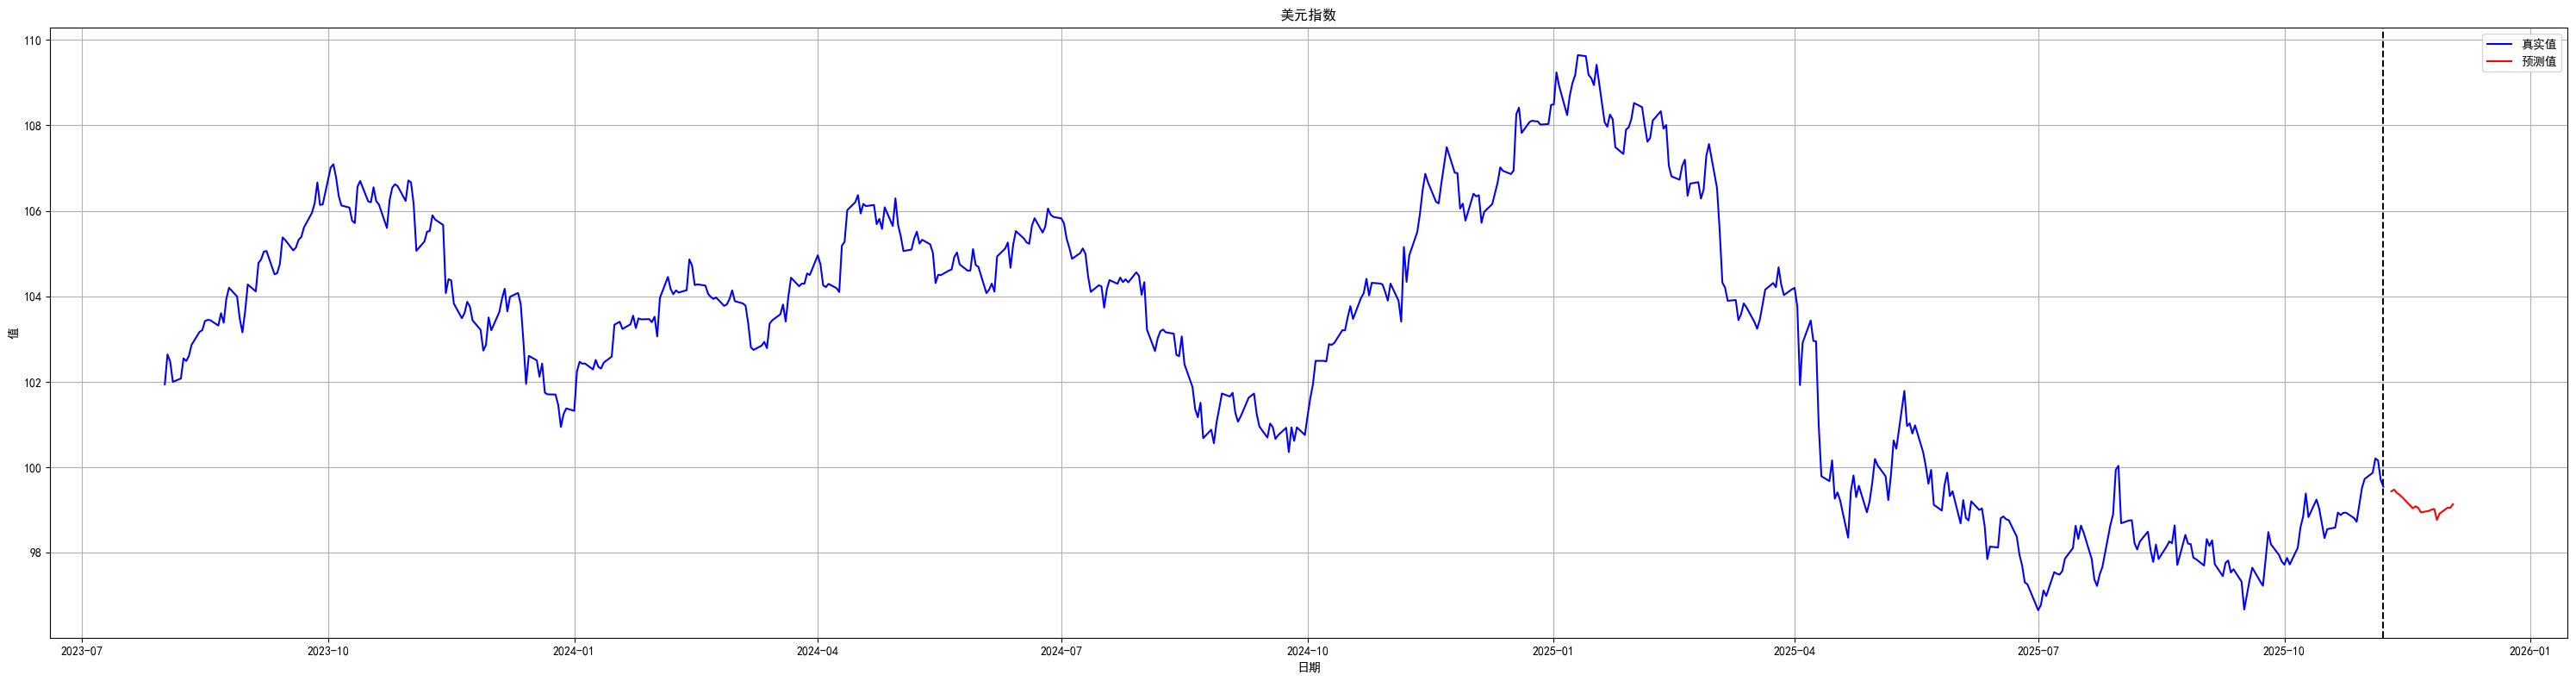

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['美元指数'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['美元指数_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('美元指数')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美元指数"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美元指数"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
